In [1]:
import re
import random
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import forceatlas2 as fa2
from tqdm.notebook import tqdm

In [25]:
from lib.imports import *
from lib.tools import *
from lib.ipyjobs import *
from lib.data import *
from lib.layouts import *
from lib.utils import *
from lib.modules import *
from lib.functions import *
from ipynb.fs.defs.losses import *

In [26]:
G_list = load_G_list(data_path='data/rome', index_file='data_index.txt', cache='G_list')

Load from './G_list.pickle'


In [27]:
data_list = generate_data_list(G_list, 
                               sparse=False, 
                               pivot_mode=None,
                               init_mode=None,
                               edge_index="full_edge_index",
                               edge_attr="full_edge_attr",
                               pmds_list=np.load('pos_pmds.npy', allow_pickle=True),
                               gviz_list=np.load('pos_gviz.npy', allow_pickle=True),
                               noisy_layout=True,
                               device='cpu', 
                               cache=True)

Load from './generate_data_list(list,sparse=False,pivot_mode=None,init_mode=None,edge_index=full_edge_index,edge_attr=full_edge_attr,pmds_list=ndarray,gviz_list=ndarray,noisy_layout=True,device=cpu).pickle'


In [28]:
def interpolate(layout1, layout2, r):
    return {node: tuple(np.average([layout1[node], layout2[node]], axis=0, weights=(1-r, r))) for node in layout1}

In [29]:
def perturb(layout, r):
    std_pos = np.std(list(layout.values()))
    return {node: tuple(np.array(layout[node]) + np.random.normal(0, std_pos * r, 2)) for node in layout}

In [30]:
def flip_nodes(layout, r):
    k = int(len(layout) * r)
    indices = np.arange(len(layout))
    sample = random.sample(list(indices), k=k)
    shuffled = random.sample(sample, k=k)
    indices[sample] = shuffled
    return dict(zip(layout.keys(), np.array(list(layout.values()))[indices, :].tolist()))

In [31]:
def flip_edges(G, layout, r):
    k = int(G.number_of_edges() * r)
    sample = random.sample(list(G.edges), k=k)
    new_layout = dict(layout)
    for node1, node2 in sample:
        pos1, pos2 = new_layout[node1], new_layout[node2]
        new_layout[node1], new_layout[node2] = pos2, pos1
    return new_layout

In [32]:
def movlsq(layout, n, r):
    v = np.array(list(layout.values()))
    p = np.array(random.sample(list(v), n))

    std_pos = np.std(v)
    distortion = np.random.normal(0, std_pos * r, p.shape)

    q = p + distortion

    p0grid, v0grid = np.meshgrid(p[:,0], v[:,0])
    p1grid, v1grid = np.meshgrid(p[:,1], v[:,1])
    w = 1 / ((p0grid - v0grid) ** 2 + (p1grid - v1grid) ** 2 + 1e-5) 

    p_star = w @ p / np.sum(w, axis=1, keepdims=True)
    q_star = w @ q / np.sum(w, axis=1, keepdims=True)

    p_star_grid = np.repeat(p_star[:,None,:], p.shape[0], axis=1)
    p_grid = np.repeat(p[None, :,:], p_star.shape[0], axis=0)
    p_hat = p_grid - p_star_grid

    q_star_grid = np.repeat(q_star[:,None,:], q.shape[0], axis=1)
    q_grid = np.repeat(q[None, :,:], q_star.shape[0], axis=0)
    q_hat = q_grid - q_star_grid

    spwp = np.einsum('vip,vi,viq->vpq', p_hat, w, p_hat)
    spwq = np.einsum('vip,vi,viq->vpq', p_hat, w, q_hat)

    M = np.linalg.inv(spwp) @ spwq

    distorted_pos = np.einsum('vp,vpq->vq', v - p_star, M) + q_star
    distorted_layout = dict(zip(layout.keys(), distorted_pos.tolist()))
    return distorted_layout

In [33]:
def get_gviz_layout(G):
    layout = nx.nx_agraph.graphviz_layout(G, prog='neato')
    return layout

In [34]:
def get_sfdp_layout(G):
    layout = nx.nx_agraph.graphviz_layout(G, prog="sfdp")
    return layout

In [35]:
def get_fa2_layout(G):
    layout = fa2.forceatlas2_networkx_layout(G)
    return layout

In [36]:
def get_random_normal_layout(G, r=1):
    proper_layout = get_proper_layout(G)
    mean_pos = np.mean(list(proper_layout.values()))
    std_pos = np.std(list(proper_layout.values()))
    random_layout = {node: tuple(np.random.normal(mean_pos, std_pos, 2)) for node in proper_layout}
    return interpolate(proper_layout, random_layout, r=r)

In [37]:
def get_random_uniform_layout(G, r=1):
    proper_layout = get_proper_layout(G)
    min_pos = np.min(list(proper_layout.values()), axis=0)
    max_pos = np.max(list(proper_layout.values()), axis=0)
    random_layout = {node: tuple(np.random.uniform(min_pos, max_pos)) for node in proper_layout}
    return interpolate(proper_layout, random_layout, r=r)

In [38]:
def get_phantom_layout(G, r=1):
    n = G.number_of_nodes()
    m = G.number_of_edges()
    phantom = nx.generators.random_graphs.gnm_random_graph(n, m)
    phantom_layout = get_proper_layout(phantom)
    proper_layout = get_proper_layout(G)
    random_layout = dict(zip(G.nodes, phantom_layout.values()))
    return interpolate(proper_layout, random_layout, r=r)

In [39]:
def get_perturb_layout(G, r=1):
    proper_layout = get_proper_layout(G)
    return perturb(proper_layout, r=r)

In [40]:
def get_flip_nodes_layout(G, r=1):
    proper_layout = get_proper_layout(G)
    return flip_nodes(proper_layout, r=r)

In [41]:
def get_flip_edges_layout(G, r=1):
    proper_layout = get_proper_layout(G)
    return flip_edges(G, proper_layout, r=r)

In [42]:
def get_movlsq_layout(G, r=1):
    layout = get_proper_layout(G)
    return movlsq(layout, 5, r)

In [75]:
def get_stress(layout, data):
    criterion = NormalizedStressLoss()
    pos = torch.tensor(list(layout.values()))
    batch = Batch.from_data_list([data])
    rescaled = rescale_with_minimized_stress(pos, batch)
    return criterion(rescaled, batch).item()

In [44]:
fns = {
    'random_normal': get_random_normal_layout,
    'random_uniform': get_random_uniform_layout,
    'phantom': get_phantom_layout,
    'perturb': get_perturb_layout,
    'flip_nodes': get_flip_nodes_layout,
    'flip_edges': get_flip_edges_layout,
    'movlsq': get_movlsq_layout
}

In [45]:
get_proper_layout = get_gviz_layout

In [71]:
G = G_list[100]
data = data_list[100]

In [72]:
pos = get_proper_layout(G)

In [76]:
get_stress(pos, data)

251.67977905273438

$$\frac{\sigma_{garbage}}{\sigma_{proper}} = 1 - r$$

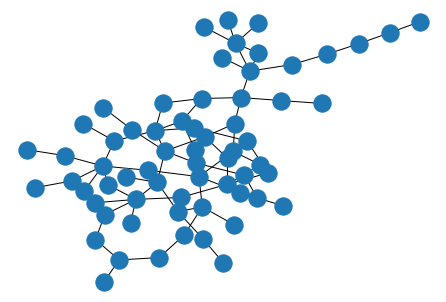

In [74]:
nx.draw(G, pos)

In [78]:
pos = []
r = []
stress = []
for layout in fns:
    for _ in tqdm(range(100)):
        r.append(random.random())
        pos.append(fns[layout](G, r[-1]))
        stress.append(get_stress(pos[-1], data))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

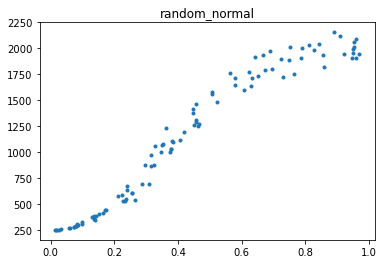

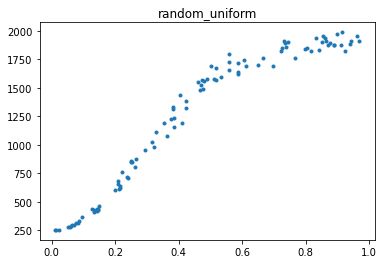

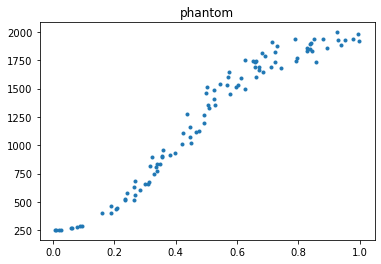

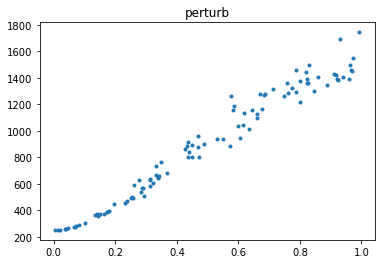

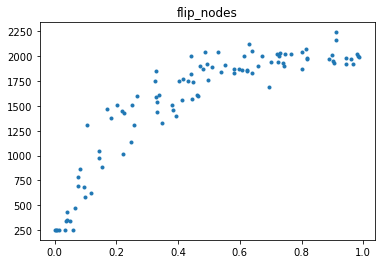

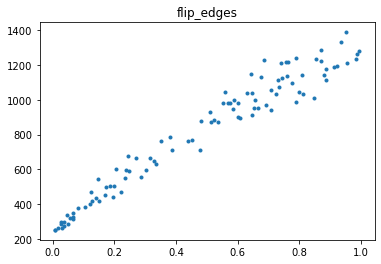

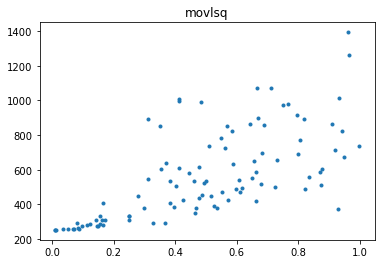

In [80]:
for i, fn in zip(range(0, 700, 100), fns):
    plt.plot(r[i:i+100], stress[i:i+100], '.')
    plt.title(fn)
    plt.show()

In [33]:
pos = []
for layout in fns:
    for _ in tqdm(range(100)):
        pos.append(np.array(list(fns[layout](G, random.random()).values())))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
pickle.dump({'G': G_list[4900], 'pos': pos}, open('G4900.pickle', 'wb'))

In [35]:
G = G_list[10000]

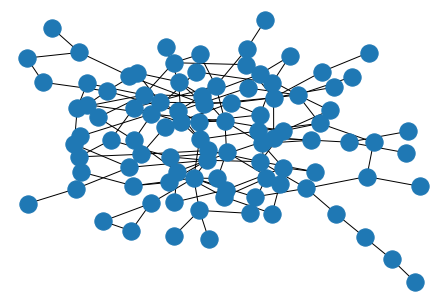

In [36]:
nx.draw(G, get_proper_layout(G))

In [37]:
pos = []
for layout in fns:
    for _ in tqdm(range(100)):
        pos.append(np.array(list(fns[layout](G, random.random()).values())))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [40]:
len(pos)

700

In [44]:
pickle.dump({'G': G_list[10000], 'pos': pos}, open('G10000.pickle', 'wb'))

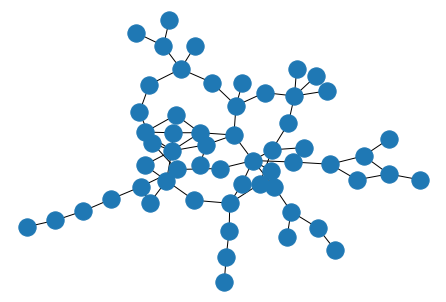

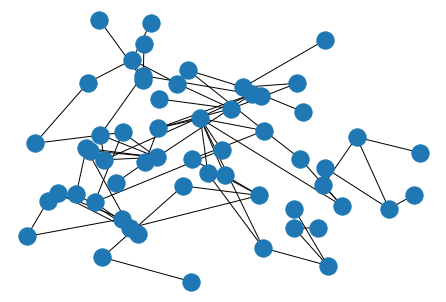

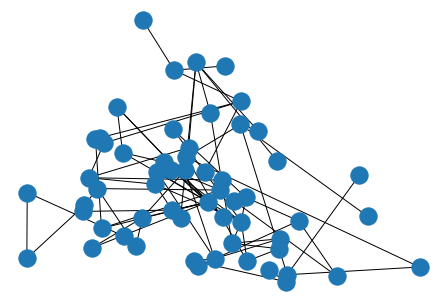

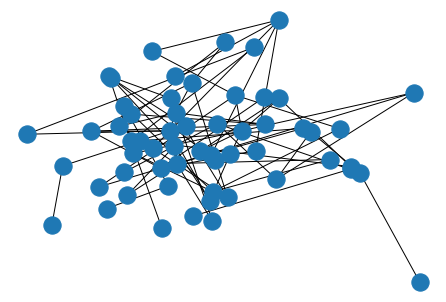

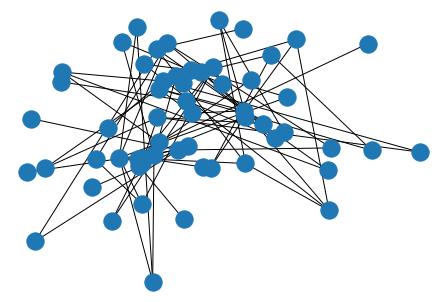

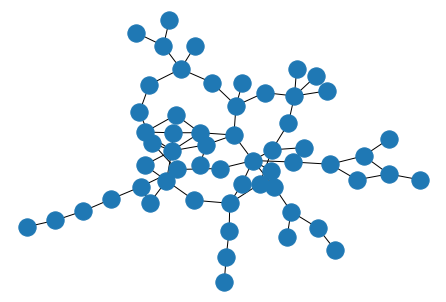

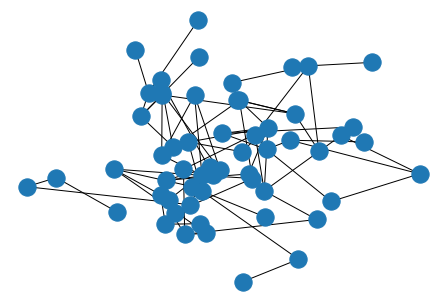

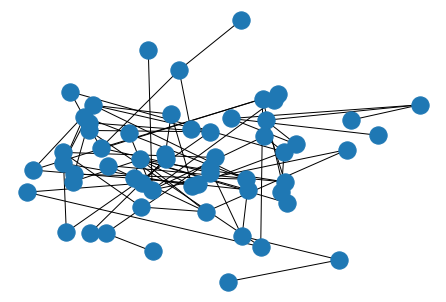

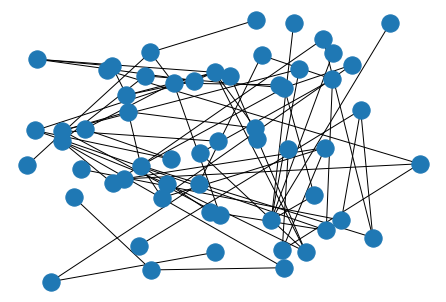

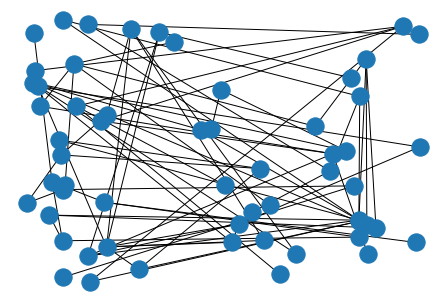

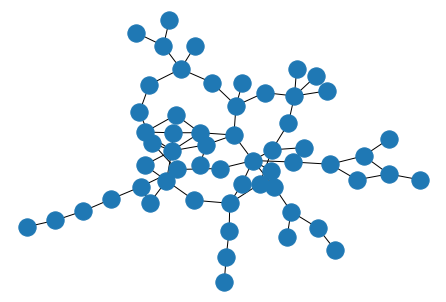

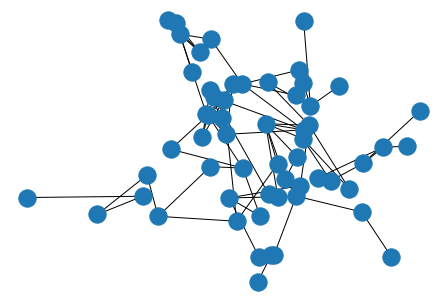

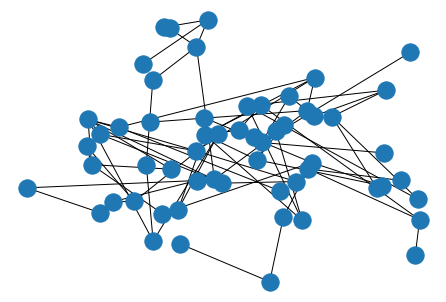

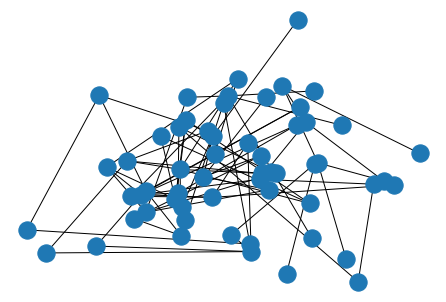

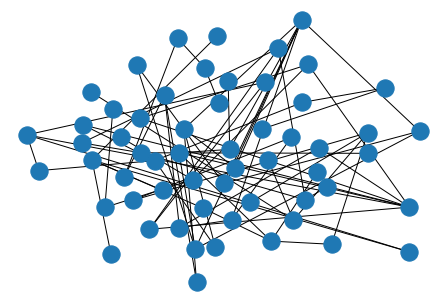

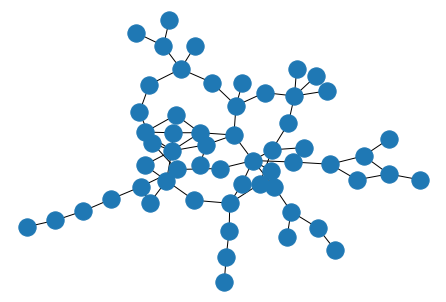

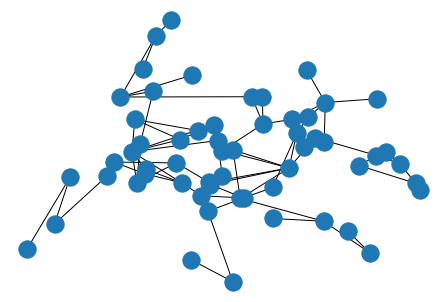

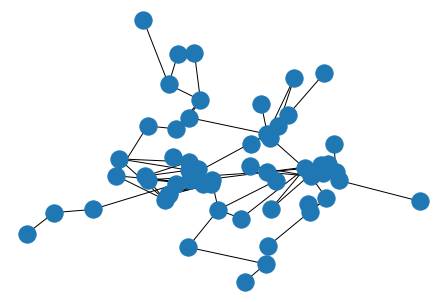

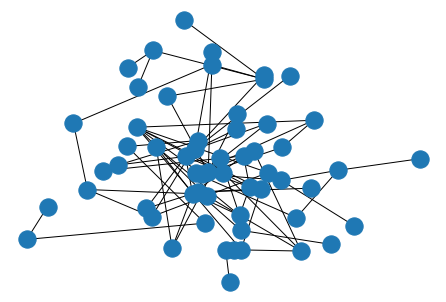

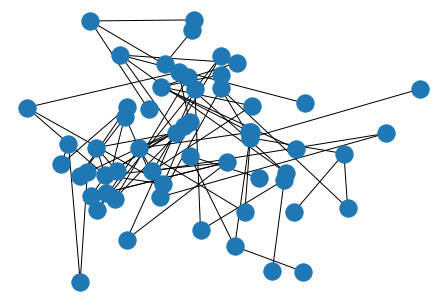

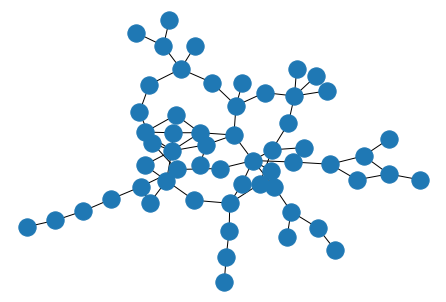

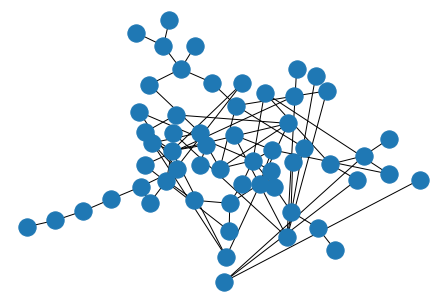

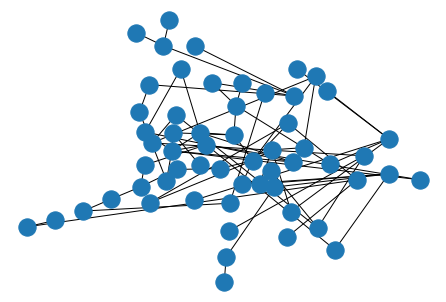

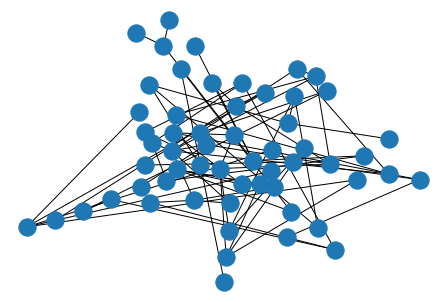

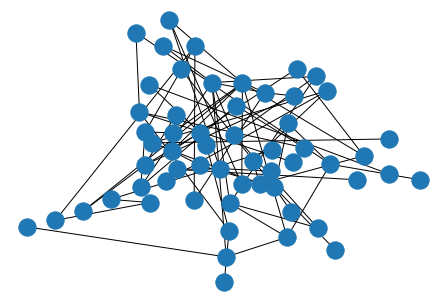

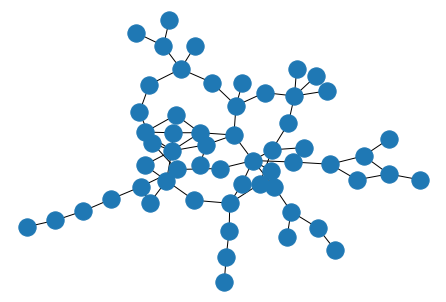

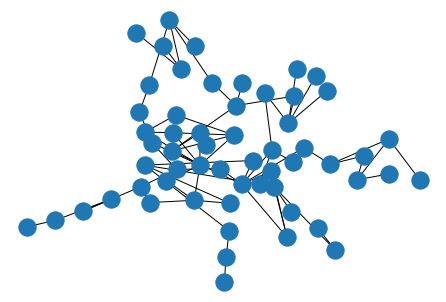

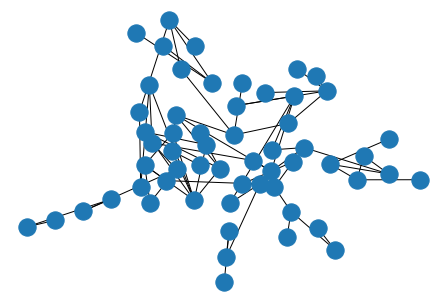

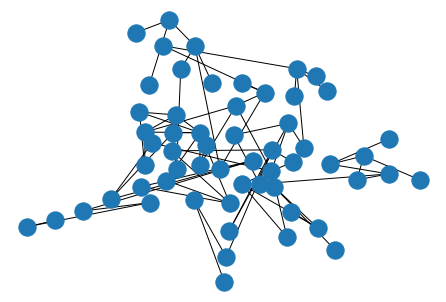

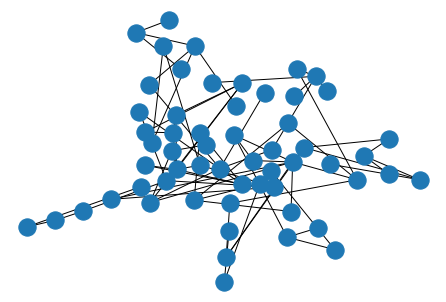

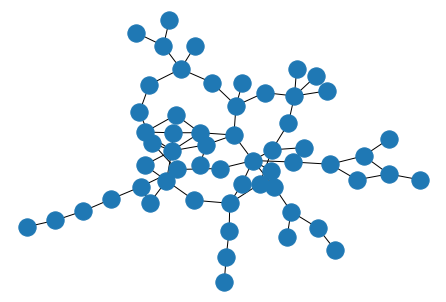

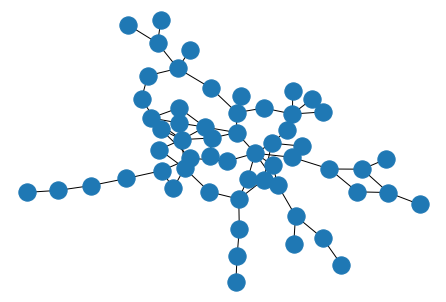

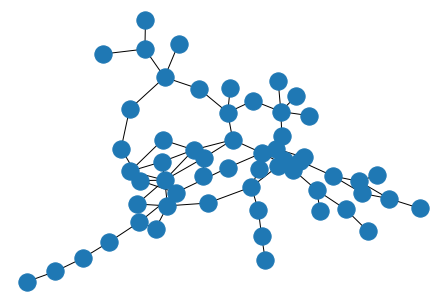

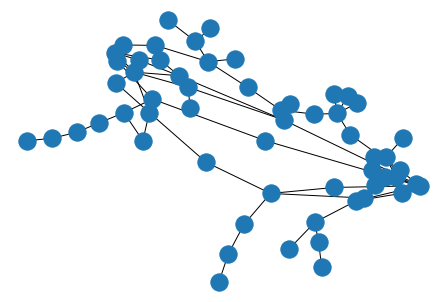

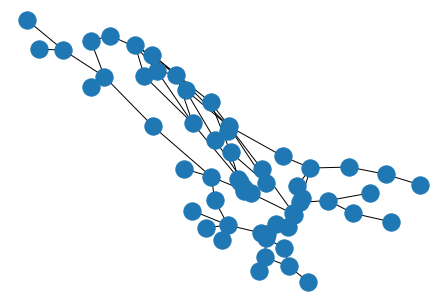

In [27]:
for fn in fns:
    for r in [0, 0.3, 0.5, 0.7, 1]:
        nx.draw(G, fns[fn](G, r))
        plt.savefig(f'layouts/{fn}_{r}.png')
        plt.show()

In [50]:
def init_job_manager():
    from IPython import get_ipython
    from IPython.core.magic import register_line_cell_magic
    from IPython.lib.backgroundjobs import BackgroundJobManager
    
    if jobs not in globals() or type(jobs) is not BackgroundJobManager:
        global jobs
        jobs = BackgroundJobManager()

    @register_line_cell_magic
    def job(line, cell=None):
        jobs.new(cell or line, get_ipython().user_global_ns)

init_job_manager()

In [40]:
def get_proper_layout(G):
    return get_sfdp_layout(G)

In [31]:
def generate_layout(G_list, fn, name):
    layouts = []
    for G in tqdm(G_list):
        r = random.random()
        layouts.append((fn(G, r=r), r))
    pickle.dump(layouts, open(f'{name}.pickle', 'wb'))

In [68]:
def generate_proper_layout(G_list, fn, name):
    layouts = []
    for G in tqdm(G_list):
        layouts.append((fn(G), 0))
    pickle.dump(layouts, open(f'{name}.pickle', 'wb'))

In [73]:
pickle.load(open('gviz.pickle', 'rb'))[1503]

({'n0': (195.05, 185.71),
  'n1': (236.85, 118.14),
  'n2': (172.24, 101.16),
  'n3': (180.99, 18.0),
  'n4': (110.17, 163.13),
  'n5': (527.5, 284.83),
  'n6': (307.38, 332.39),
  'n7': (174.78, 455.46),
  'n8': (386.43, 362.44),
  'n9': (348.86, 396.52),
  'n10': (260.75, 250.93),
  'n11': (381.13, 282.4),
  'n12': (680.64, 254.63),
  'n13': (125.83, 227.2),
  'n14': (302.79, 423.45),
  'n15': (27.0, 175.48),
  'n16': (93.153, 84.626),
  'n17': (456.41, 237.66),
  'n18': (338.71, 211.69),
  'n19': (538.11, 348.63),
  'n20': (226.99, 385.46),
  'n21': (206.97, 308.81),
  'n22': (606.19, 264.97),
  'n23': (254.39, 475.09),
  'n24': (455.7, 318.8),
  'n25': (258.51, 379.94),
  'n26': (471.58, 366.59),
  'n27': (413.25, 169.62)},
 0)

In [76]:
pickle.dump(G_list, open('gan_G_list.pickle', 'wb'))

In [ ]:
generate_proper_layout(G_list, get_gviz_layout, 'gviz')

In [10]:
generate_proper_layout(G_list, get_sfdp_layout, 'sfdp')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [13]:
generate_proper_layout(G_list, get_fa2_layout, 'fa2')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [32]:
generate_layout(G_list, get_random_normal_layout, 'sfdp_random_normal')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [33]:
generate_layout(G_list, get_random_uniform_layout, 'sfdp_random_uniform')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [34]:
generate_layout(G_list, get_phantom_layout, 'sfdp_phantom')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [35]:
generate_layout(G_list, get_perturb_layout, 'sfdp_perturb')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [52]:
%%job
generate_layout(G_list, get_flip_nodes_layout, 'sfdp_flip_nodes')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [44]:
%%job
generate_layout(G_list, get_flip_edges_layout, 'sfdp_flip_edges')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [43]:
%%job
generate_layout(G_list, get_movlsq_layout, 'sfdp_movlsq')

  0%|          | 0/11534 [00:00<?, ?it/s]

In [43]:
random_normal_layouts = pickle.load(open('random_normal.pickle', 'rb'))
random_uniform_layouts = pickle.load(open('random_uniform.pickle', 'rb'))
phantom_layouts = pickle.load(open('phantom.pickle', 'rb'))
perturb_layouts = pickle.load(open('perturb.pickle', 'rb'))
flip_nodes_layouts = pickle.load(open('flip_nodes.pickle', 'rb'))
flip_edges_layouts = pickle.load(open('flip_edges.pickle', 'rb'))
movlsq_layouts = pickle.load(open('movlsq.pickle', 'rb'))

In [67]:
idx = 10030

0.9238788076448337

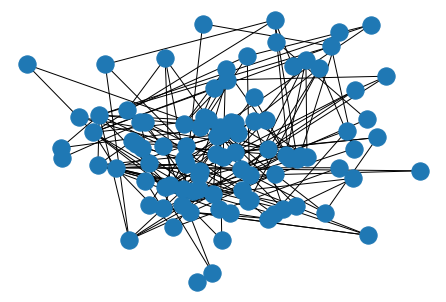

In [75]:
nx.draw(G_list[idx], random_normal_layouts[idx][0])
random_normal_layouts[idx][1]

0.5923170705097599

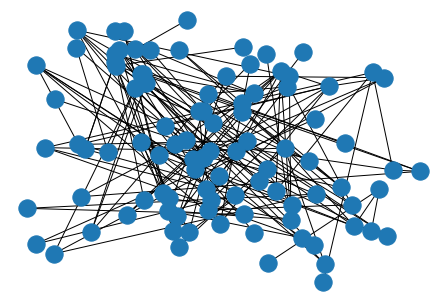

In [76]:
nx.draw(G_list[idx], random_uniform_layouts[idx][0])
random_uniform_layouts[idx][1]

0.08808981948075345

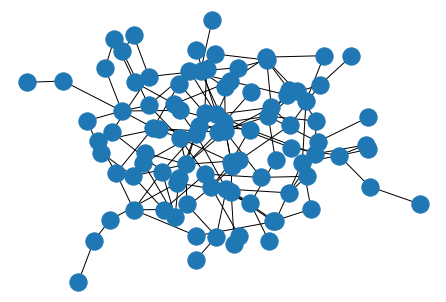

In [77]:
nx.draw(G_list[idx], phantom_layouts[idx][0])
phantom_layouts[idx][1]

0.5931497641719975

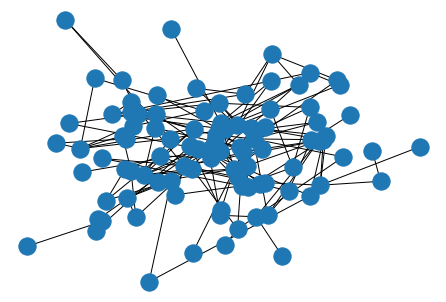

In [78]:
nx.draw(G_list[idx], perturb_layouts[idx][0])
perturb_layouts[idx][1]

0.7110864081602196

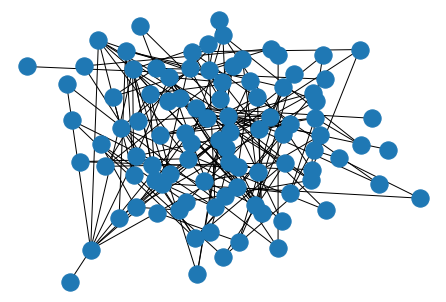

In [79]:
nx.draw(G_list[idx], flip_nodes_layouts[idx][0])
flip_nodes_layouts[idx][1]

0.6858434288389507

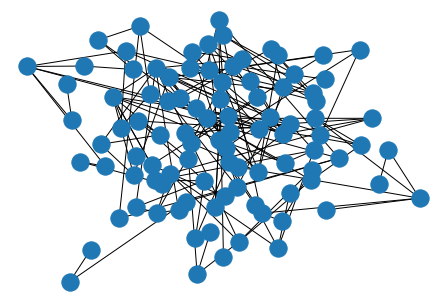

In [80]:
nx.draw(G_list[idx], flip_edges_layouts[idx][0])
flip_edges_layouts[idx][1]

0.2840577072721012

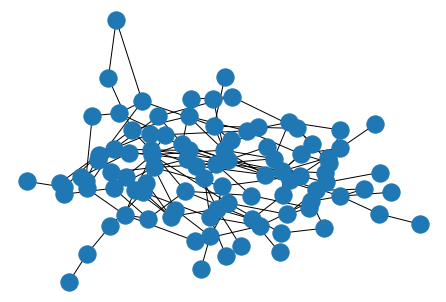

In [81]:
nx.draw(G_list[idx], movlsq_layouts[idx][0])
movlsq_layouts[idx][1]